In [1]:
# define a model using pytorch
# a pretrained model adding layers to classify the 4 classes of the images
import torch.nn as nn
from torchvision import models
from torchvision.models import squeezenet1_1
from torchvision.models.squeezenet import SqueezeNet1_1_Weights



class MIDmodel(nn.Module):
    def __init__(self):
        super(MIDmodel, self).__init__()
        self.pretrained = squeezenet1_1()
        self.fc1 = nn.Linear(1000, 128)
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, root_dir, patients_ids, patients_df, transform=None):
        # select the rows of the dataframe that correspond to the patients in the list
        self.patients_df = patients_df[patients_df["patient_id"].isin(patients_ids)]
        self.root_dir = root_dir
        self.idxs = set()
        if transform:
            self.transform = transform
            # duplicate the patients_df, so the network will see each image twice, one standard and one transformed
            # self.patients_df = pd.concat([self.patients_df] * 2, ignore_index=True)
        else:
            self.transform = None
               
            
    def __len__(self):
        return len(self.patients_df)

    def __getitem__(self, idx):
        # get idx row of the dataframe
        row = self.patients_df.iloc[idx]
        # path = root_dir/patientid_examid_spot_framenumber_score.png
        path = os.path.join(self.root_dir, row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")
        image = Image.open(path)
        label = row["score"]
        # if the image is grayscale, convert it to RGB (used to test with the smaller dataset)
        # if image.mode != "RGB":
        #     image = image.convert("RGB")
               
        if self.transform:
            image = self.transform(image)
            # if path not in self.idxs: # if it's the first time we see the image, add its path to the set
            #     self.idxs.add(path)
            # else: # if it's the second time we see the image, apply the transform and remove its path from the set 
            #     image = self.transform(image)
            #     self.idxs.remove(path)
        # in any case, transform to tensor
        image = transforms.ToTensor()(image)
        image = transforms.Resize((224, 224))(image)
        # Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        return image, int(label)

In [3]:
import pandas as pd
import torch
import glob
data_dir = "images/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images_paths = glob.glob(f"{data_dir}*.png", recursive=True)
# images are named as: patientid_examid_spotnumber_framenumber_score.png
# create a dataframe with the data removing "images/"
images_df = pd.DataFrame([path[len(data_dir):-4].split("_") for path in images_paths], columns=["patient_id", "exam_id", "spot", "frame_number", "score"])
images_df["score"] = images_df["score"].astype(str)
images_df["frame_number"] = images_df["frame_number"].astype(str)
images_df["spot"] = images_df["spot"].astype(str)
images_df["patient_id"] = images_df["patient_id"].astype(str)
images_df["exam_id"] = images_df["exam_id"].astype(str)
patients_ids = set(images_df["patient_id"])
patients_ids = list(patients_ids)

# select the 8 patients for training based on the most balanced distribution of the scores
import itertools
combs = list(itertools.combinations(patients_ids, 8))
stds = []
for i, c in enumerate(combs):
    stds.append((images_df[images_df["patient_id"].isin(c)].groupby("score").count()["patient_id"].std(), i))

train_patients = [x for x in combs[min(stds)[1]]]
print(train_patients)
print(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"])
test_patients = [x for x in patients_ids if x not in train_patients]
print(test_patients)
print(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"])


['1048', '1047', '1017', '1069', '1067', '1051', '1052', '1050']
score
0    7888
1    7540
2    7189
3    7592
Name: patient_id, dtype: int64
['1045', '1066', '1068']
score
0    6625
1    1721
2    5535
3    3631
Name: patient_id, dtype: int64


transformations from the paper Deep Learning for Classification and Localization of COVID-19 Markers in Point-of-Care Lung Ultrasound
were each activated on the image-label pair with a probability of 0.33. The set of augmentation functions, each applied with a randomly sampled strength bounded by a set maximum, consists of:
- affine transformations (translation (max. ±15%), rotation (max. ±15◦), scaling (max. ±45%), and shearing (max. ±4.5◦))
- multiplication with a constant (max. ±45%)
- Gaussian blurring (σmax = 3/4 )
- contrast distortion (max. ±45%)
- horizontal flipping (p = 0.5)
- additive white Gaussian noise (σmax = 0.015)

In [4]:
transformations = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.55, 1.45), shear=4.5)], p=1/3),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.45, contrast=0.45, saturation=0.45, hue=0.45)], p=1/3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.75))], p=1/3),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=1/3)
    ])

In [5]:
from torch import optim
from tqdm import tqdm

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects/ len(dataloader.dataset)
    return epoch_loss, epoch_acc

def test_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc


In [6]:
data_dir = "images/"
num_epochs = 10
learning_rate = 0.00001
batch_size = 8

model = MIDmodel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_dataset = ImageDataset(data_dir, train_patients, images_df, transformations)
test_dataset = ImageDataset(data_dir, test_patients, images_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
results_train = []
results_test = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    results_train.append([train_loss, train_acc])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(model, test_dataloader, criterion, device)
    results_test.append([test_loss, test_acc])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f"MIDmodel_{epoch}.pt")
    if epoch % 2 == 1:
        learning_rate = learning_rate/2
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Train: ", results_train)
print("Test: ", results_test)

# save the model
torch.save(model.state_dict(), f"MIDmodel.pt")

Epoch 0


100%|██████████| 3777/3777 [17:01<00:00,  3.70it/s]


Training Loss: 1.4453 Training Accuracy: 0.2713


100%|██████████| 2189/2189 [04:26<00:00,  8.21it/s]


Test Loss: 1.3651 Test Accuracy: 0.3936
Epoch 1


100%|██████████| 3777/3777 [16:30<00:00,  3.81it/s]


Training Loss: 1.2787 Training Accuracy: 0.4056


100%|██████████| 2189/2189 [04:31<00:00,  8.05it/s]


Test Loss: 1.3009 Test Accuracy: 0.4223
Epoch 2


100%|██████████| 3777/3777 [17:32<00:00,  3.59it/s]


Training Loss: 1.0871 Training Accuracy: 0.5218


100%|██████████| 2189/2189 [04:25<00:00,  8.25it/s]


Test Loss: 1.5074 Test Accuracy: 0.3301
Epoch 3


100%|██████████| 3777/3777 [17:42<00:00,  3.56it/s]


Training Loss: 0.9238 Training Accuracy: 0.6007


100%|██████████| 2189/2189 [04:17<00:00,  8.49it/s]


Test Loss: 1.6293 Test Accuracy: 0.4055
Epoch 4


100%|██████████| 3777/3777 [16:56<00:00,  3.72it/s]


Training Loss: 0.8184 Training Accuracy: 0.6576


100%|██████████| 2189/2189 [04:08<00:00,  8.79it/s]


Test Loss: 1.5699 Test Accuracy: 0.4069
Epoch 5


100%|██████████| 3777/3777 [16:41<00:00,  3.77it/s]


Training Loss: 0.7403 Training Accuracy: 0.6972


100%|██████████| 2189/2189 [04:18<00:00,  8.46it/s]


Test Loss: 1.5488 Test Accuracy: 0.4343
Epoch 6


100%|██████████| 3777/3777 [16:40<00:00,  3.78it/s]


Training Loss: 0.6809 Training Accuracy: 0.7247


100%|██████████| 2189/2189 [04:02<00:00,  9.02it/s]


Test Loss: 1.4956 Test Accuracy: 0.4344
Epoch 7


100%|██████████| 3777/3777 [16:38<00:00,  3.78it/s]


Training Loss: 0.6463 Training Accuracy: 0.7430


100%|██████████| 2189/2189 [04:32<00:00,  8.03it/s]


Test Loss: 1.7523 Test Accuracy: 0.4585
Epoch 8


100%|██████████| 3777/3777 [16:42<00:00,  3.77it/s]


Training Loss: 0.6038 Training Accuracy: 0.7579


100%|██████████| 2189/2189 [04:23<00:00,  8.30it/s]


Test Loss: 1.4515 Test Accuracy: 0.4854
Epoch 9


100%|██████████| 3777/3777 [16:44<00:00,  3.76it/s]


Training Loss: 0.5772 Training Accuracy: 0.7737


100%|██████████| 2189/2189 [03:58<00:00,  9.18it/s]

Test Loss: 1.5062 Test Accuracy: 0.4978
Train:  [[1.4453151551324965, tensor(0.2713, device='cuda:0')], [1.278736829047383, tensor(0.4056, device='cuda:0')], [1.0870531683799356, tensor(0.5218, device='cuda:0')], [0.923765770988631, tensor(0.6007, device='cuda:0')], [0.8183876516514437, tensor(0.6576, device='cuda:0')], [0.7402640066483773, tensor(0.6972, device='cuda:0')], [0.6809365507032136, tensor(0.7247, device='cuda:0')], [0.6463492192383963, tensor(0.7430, device='cuda:0')], [0.6037752303301651, tensor(0.7579, device='cuda:0')], [0.5771569872453134, tensor(0.7737, device='cuda:0')]]
Test:  [[1.3650751340982847, tensor(0.3936, device='cuda:0')], [1.3009044412419697, tensor(0.4223, device='cuda:0')], [1.507390807594214, tensor(0.3301, device='cuda:0')], [1.6292844691393364, tensor(0.4055, device='cuda:0')], [1.5698632373725132, tensor(0.4069, device='cuda:0')], [1.5488062066295345, tensor(0.4343, device='cuda:0')], [1.4955579021049161, tensor(0.4344, device='cuda:0')], [1.75228601

Classifier to predict if the confidence is high enough, created on the entire dataset

In [8]:
# load the last model
model = MIDmodel()
model.load_state_dict(torch.load("MIDmodel.pt"))
model.to(device)
model.eval()

correct_preds = pd.DataFrame(columns=["true", "predicted", "sm0", "sm1", "sm2", "sm3"])
wrong_preds = pd.DataFrame(columns=["true", "predicted", "sm0", "sm1", "sm2", "sm3"])

entire_dataset = ImageDataset(data_dir, patients_ids, images_df)

for i in tqdm(range(len(train_dataset))):
    img, label = train_dataset[i]
    img = img.unsqueeze(0)
    img = img.to(device)
    output = model(img)
    sm = nn.Softmax(dim=1)
    sm = sm(output)
    sm = sm.cpu().detach().numpy()
    sm = sm[0]
    if torch.argmax(output) == label:
        correct_preds = pd.concat([correct_preds, pd.DataFrame([[label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["true", "predicted", "sm0", "sm1", "sm2", "sm3"])])
    else:
        wrong_preds = pd.concat([wrong_preds, pd.DataFrame([[label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["true", "predicted", "sm0", "sm1", "sm2", "sm3"])])

correct_preds.to_csv("correct_preds_train.csv", index=False)
wrong_preds.to_csv("wrong_preds_train.csv", index=False)


100%|██████████| 30209/30209 [17:40<00:00, 28.49it/s]


DL model to binary classify images

Epoch 0


100%|██████████| 3777/3777 [00:15<00:00, 248.97it/s]


Training Loss: 0.6199 Training Accuracy: 0.8095


100%|██████████| 2189/2189 [00:07<00:00, 297.10it/s]


Test Loss: 0.7063 Test Accuracy: 0.4978
Epoch 1


100%|██████████| 3777/3777 [00:15<00:00, 246.44it/s]


Training Loss: 0.6188 Training Accuracy: 0.8095


100%|██████████| 2189/2189 [00:08<00:00, 263.35it/s]


Test Loss: 0.7064 Test Accuracy: 0.4978
Epoch 2


100%|██████████| 3777/3777 [00:18<00:00, 205.57it/s]


Training Loss: 0.6186 Training Accuracy: 0.8095


100%|██████████| 2189/2189 [00:08<00:00, 259.36it/s]


Test Loss: 0.7064 Test Accuracy: 0.4978
Epoch 3


100%|██████████| 3777/3777 [00:16<00:00, 229.84it/s]


Training Loss: 0.6185 Training Accuracy: 0.8095


100%|██████████| 2189/2189 [00:08<00:00, 273.22it/s]


Test Loss: 0.7064 Test Accuracy: 0.4978
Train:  [[0.619903851014752, 0.8095269799232483], [0.6187732828232062, 0.8095269799232483], [0.6185694548838969, 0.8095269799232483], [0.6184581930644699, 0.8095269799232483]]
Test:  [[0.7063109235656811, 0.4978300631046295], [0.7063664749584659, 0.4978300631046295], [0.706422130584499, 0.4978300631046295], [0.7064271305401394, 0.4978300631046295]]


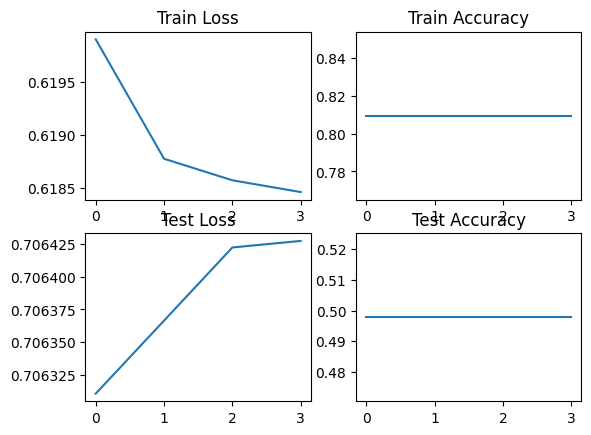

In [20]:

class MIDbinary(nn.Module):
    def __init__(self):
        super(MIDbinary, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc4 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x
    
# BinaryDataset
class BinaryDataset(Dataset):
    def __init__(self, preds):
        self.preds = preds

    def __len__(self):
        return len(self.preds)

    def __getitem__(self, idx):
        label = self.preds.iloc[idx]["correct"]
        sms = self.preds.iloc[idx][["sm0", "sm1", "sm2", "sm3"]]
        sms = torch.tensor(list(sms.values), dtype=torch.float32)
        return sms, int(label)

# train the binary model
binary_model = MIDbinary()
binary_model = binary_model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)

correct_preds = pd.read_csv("correct_preds_train.csv")
wrong_preds = pd.read_csv("wrong_preds_train.csv")

# add a clumn to correct_preds and wrong_preds that says if it's correct or not
correct_preds["correct"] = 1
wrong_preds["correct"] = 0
# stack the two dataframes
preds_total = pd.concat([correct_preds, wrong_preds])
# remove true and predicted columns
preds_total = preds_total.drop(["true", "predicted"], axis=1)
# save the values
# preds_total.to_csv("values_train.csv", index=False)

train_values = pd.read_csv("values_train.csv")
test_values = pd.read_csv("values_test.csv")


train_dataset_bin = BinaryDataset(train_values)
test_dataset_bin = BinaryDataset(test_values)
train_dataloader_bin = DataLoader(train_dataset_bin, batch_size=batch_size, shuffle=True)
test_dataloader_bin = DataLoader(test_dataset_bin, batch_size=batch_size, shuffle=True)

results_train = []
results_test = []
num_epochs = 4

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(binary_model, train_dataloader_bin, optimizer, criterion, device)
    results_train.append([train_loss, train_acc.item()])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(binary_model, test_dataloader_bin, criterion, device)
    results_test.append([test_loss, test_acc.item()])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    if( epoch > 0  and (results_train[len(results_train)-1][0] >=  results_train[len(results_train)-2][0])):
        print(results_train[len(results_train)-1], results_train[len(results_train)-2])
        print("Overfitting")
        break
    if epoch % 2 == 0:
        learning_rate = learning_rate/10
        optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)

print("Train: ", results_train)
print("Test: ", results_test)

import matplotlib.pyplot as plt
# subplots with train[0], train[1], test[0], test[1]
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot([i[0] for i in results_train])
axs[0, 0].set_title("Train Loss")
axs[0, 1].plot([i[1] for i in results_train])
axs[0, 1].set_title("Train Accuracy")
axs[1, 0].plot([i[0] for i in results_test])
axs[1, 0].set_title("Test Loss")
axs[1, 1].plot([i[1] for i in results_test])
axs[1, 1].set_title("Test Accuracy")
plt.show()



In [22]:
model = MIDmodel()
model.load_state_dict(torch.load("MIDmodel.pt"))
model.to(device)
model.eval()

# get the predictions for the test set and pass it to the binary model
usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    # print(sm)
    binary_output = binary_model(sm)
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    predicted_binary = torch.argmax(binary_output).cpu().detach().numpy()
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1

print("Usefulness of the binary model (test set):")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)

100%|██████████| 17512/17512 [04:37<00:00, 63.14it/s]

Usefulness of the binary model (test set):
Useful:  8718
Useful[%]:  49.78300593878483
Useless:  8794
Useless[%]:  50.21699406121517


In [23]:
# simple binary classificator with svc
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# load the values
preds_train = pd.read_csv("values_train.csv")
pred_test = pd.read_csv("values_test.csv")

# X_train, X_test, y_train, y_test = train_test_split(preds_total.drop("correct", axis=1), preds_total["correct"], test_size=0.2)

clf = SVC()
clf.fit(preds_train.drop("correct", axis=1), preds_train["correct"])
y_pred = clf.predict(pred_test.drop("correct", axis=1))
print("Accuracy: ", accuracy_score(pred_test["correct"], y_pred))
# save clf to file
import pickle
pickle.dump(clf, open("svc.pkl", "wb"))


Accuracy:  0.5412859753312015


In [24]:
model = MIDmodel()
model.load_state_dict(torch.load("MIDmodel.pt"))
model.to(device)
model.eval()
# read svc model from file
clf = pickle.load(open("svc.pkl", 'rb'))
entire_dataset = ImageDataset(data_dir, patients_ids, images_df)

# get the predictions for the test set and pass it to the binary model
usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    sm =sm.cpu().detach().numpy()
    binary_output = clf.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    predicted_binary = binary_output[0]
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1


print("Usefulness of the SVC (test set):")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)
    


100%|██████████| 17512/17512 [04:48<00:00, 60.63it/s]

Usefulness of the SVC (test set):
Useful:  9479
Useful[%]:  54.12859753312015
Useless:  8033
Useless[%]:  45.87140246687985


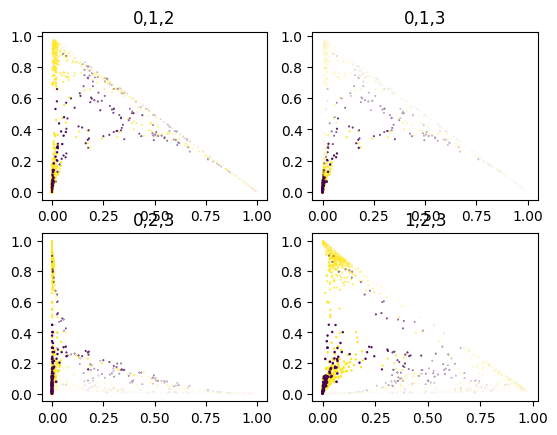

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
# read the csv file with the values
values = pd.read_csv("values.csv") #sm0, sm1, sm2, sm3, correct 
points = values[["sm0", "sm1", "sm2", "sm3"]].values
# plot the points in 4 3D plots with 0,1,2; 0,1,3; 0,2,3; 1,2,3
fig, axs = plt.subplots(2, 2)
#3D plot with 0,1,2
axs[0, 0].scatter(points[:,0], points[:,1], points[:,2], c=values["correct"])
axs[0, 0].set_title("0,1,2")
#3D plot with 0,1,3
axs[0, 1].scatter(points[:,0], points[:,1], points[:,3], c=values["correct"])
axs[0, 1].set_title("0,1,3")
#3D plot with 0,2,3
axs[1, 0].scatter(points[:,0], points[:,2], points[:,3], c=values["correct"])
axs[1, 0].set_title("0,2,3")
#3D plot with 1,2,3
axs[1, 1].scatter(points[:,1], points[:,2], points[:,3], c=values["correct"])
axs[1, 1].set_title("1,2,3")
plt.show()

t-SNE to visualize only the correct prediction (but still in both train and test)

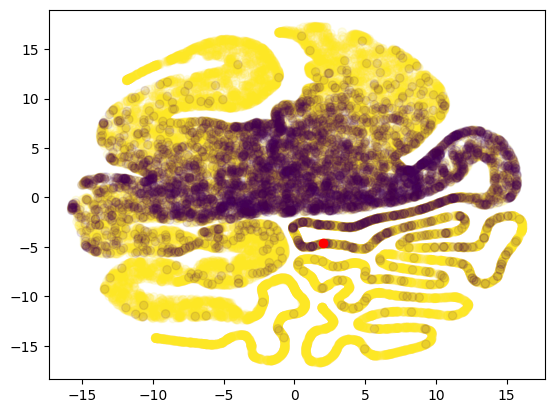

In [29]:
# impiort TNSE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# get the values
values = pd.read_csv("values_train.csv") #sm0, sm1, sm2, sm3, correct
points = values[["sm0", "sm1", "sm2", "sm3"]].values
# get the tsne values
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(points)
# plot the points
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=values["correct"], alpha=0.1)
# plt.show()

# add the first point of values_test to the tnse plot with a red color
values_test = pd.read_csv("wrong_preds_test.csv")
values_test.drop("true", axis=1)
values_test.drop("predicted", axis=1)
points_test = values_test[["sm0", "sm1", "sm2", "sm3"]].values
tsne_test = tsne.fit_transform(points_test)
plt.scatter(tsne_test[0,0], tsne_test[0,1], c="red")
plt.show()


In [ ]:
# near-duplicate image search with Locality Sensitive Hashing
# https://keras.io/examples/vision/near_dup_search/
